Import packages

In [29]:
import tensorflow as tf
import create_dataset
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Define generic functions to visualize data

In [30]:
def showImage(im):
    if (im.shape[2] == 1):
        im = im[:, :, 0]
    plt.imshow(im)
    plt.show()

Define generic functions to initialize weight/bias variables, and to define common convolution and pooling operations

In [31]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name='weights')

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name='biases')

In [32]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

Define the network architecture + loss function and metrics

In [33]:
# Input/Output placeholders
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='input')
y_ = tf.placeholder(tf.float32, shape=[None, 2], name='output')

# Layer 1
with tf.name_scope('1/Conv'):
    W_conv1 = weight_variable([3, 3, 1, 32])
    b_conv1 = bias_variable([32])
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

# Layer 2
with tf.name_scope('2/Conv'):
    W_conv2 = weight_variable([3, 3, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

# Layer 3
with tf.name_scope('3/FC'):
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
with tf.name_scope('4/Dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout
with tf.name_scope('5/Readout'):
    W_fc2 = weight_variable([1024, 1])
    b_fc2 = bias_variable([1])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
# Loss
with tf.name_scope('6/Loss'):
    y_sincos = [tf.sin(y_conv), tf.cos(y_conv)]

# Define loss
l2_loss = tf.reduce_mean(
    tf.nn.l2_loss(tf.subtract(y_sincos, y_)))
train_step = tf.train.AdamOptimizer(1e-4).minimize(l2_loss)

Train the network per-batch

step 0, training loss 2.04776
step 5, training loss 1.85335


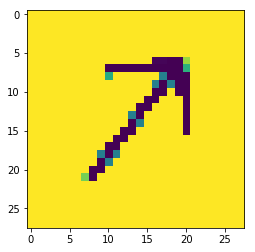

True angle: 52
True sin/cos: [ 0.78801075  0.61566148]
Predicted angle: [ 230.92359924]


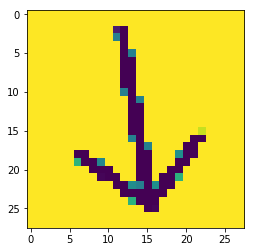

True angle: 279
True sin/cos: [-0.98768834  0.15643447]
Predicted angle: [ 15.60498047]


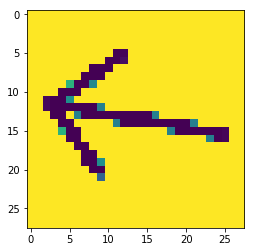

True angle: 170
True sin/cos: [ 0.17364818 -0.98480775]
Predicted angle: [ 141.390625]


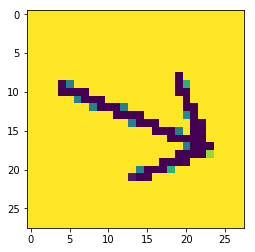

True angle: 337
True sin/cos: [-0.39073113  0.92050485]
Predicted angle: [ 244.89501953]


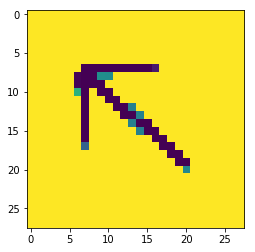

True angle: 139
True sin/cos: [ 0.65605903 -0.75470958]
Predicted angle: [ 261.60449219]


In [34]:
batch_size = 40
logging_frequency = 5
iterations = 10

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(iterations):
    batch = create_dataset.generate_data(batch_size)
    if i % logging_frequency == 0:
      loss = sess.run(l2_loss, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}) 
      print('step %d, training loss %g' % (i, loss/batch_size))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
    
  visualization_size = 5
  vis_batch = create_dataset.generate_data(visualization_size)
  output = sess.run(y_conv, feed_dict={x: vis_batch[0], y_: vis_batch[1], keep_prob: 1.0})
  for i in range(visualization_size):
    showImage(vis_batch[0][i])
    print ("True angle: " + str(vis_batch[2][i][0]))
    print ("True sin/cos: " + str(vis_batch[1][i]))
    print ("Predicted angle: " + str((output[i]*180/math.pi)%360))